In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


### Read data

In [3]:
path = 'drive/MyDrive/COMP_642_Project/Data/fer2013.csv'

In [4]:
import pandas as pd
import numpy as np

In [5]:
import random

In [68]:
data = pd.read_csv(path)
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [69]:
data.shape

(35887, 3)

In [8]:
data.dtypes

emotion     int64
pixels     object
Usage      object
dtype: object

In [9]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt

### **Information about dataset**

Each image in FER-2013 is labelled as one of seven emotions, such as happy, sad, angry, afraid, surprise, disgust, and neutral, with happy being the most prevalent emotion, providing a baseline for random guessing of 24.4%.

The labels are 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral.

In [10]:
emotion_key = {0: 'Angry', 1: 'Disgust', 2: 'Fear',
               3: 'Happy', 4: 'Sad', 5: 'Surprise',
               6: 'Neutral'}

### Data PreProcessing

In [70]:
# We try to get a distribution of emotions in the dataset
x_data = data['pixels']
y_data = data['emotion']

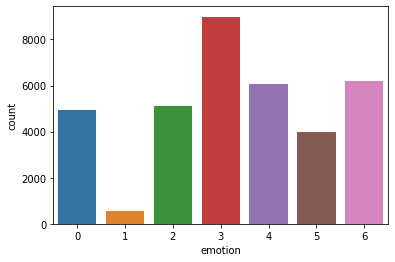

In [12]:
ax = sns.countplot(x='emotion', data=data)

In [13]:
data.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

We will use publiTest data points for validation and the privatetest data points for testing.

In [14]:
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

#### Use case 1: Dealing with data imbalance with random oversampling
The dataframe above shows that the data is imbalanced so we will need to handle the imbalanced data but first we need to convert the pixels from strings to floats.

In [15]:
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1, 1), y_data)
print(x_data.shape," ",y_data.shape)

(62923, 1)   (62923,)


In [16]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [17]:
y_data.value_counts()

0    8989
2    8989
4    8989
6    8989
3    8989
5    8989
1    8989
Name: emotion, dtype: int64

In [18]:
x_data = pd.Series(x_data.flatten())
x_data

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
62918    18 36 34 27 25 24 23 24 28 26 21 20 27 30 32 3...
62919    111 104 90 98 102 104 118 135 146 152 155 156 ...
62920    36 58 56 103 92 85 66 87 56 86 82 83 64 49 61 ...
62921    184 184 185 185 198 200 162 148 154 149 184 18...
62922    66 49 41 39 30 31 34 35 32 38 54 75 42 31 47 6...
Length: 62923, dtype: object

In [19]:
x_data = np.array(list(map(str.split, x_data)), np.float32)

In [20]:
# Normalize the pixels
x_data = x_data / 255

In [21]:
# We reshape the array from a flattened vector to its original format: 48 x 48 x 1
# channel since it is a single channel image
x_data = x_data.reshape(-1, 48, 48, 1)

In [22]:
x_data.shape

(62923, 48, 48, 1)

In [23]:
x_data[0].shape

(48, 48, 1)

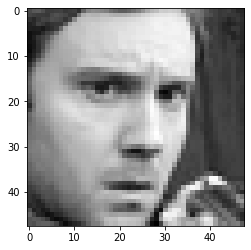

In [24]:
# To show the images, we use the np.squeeze function for the single channel image 
# to be displayed by matplotlib
# https://stackoverflow.com/questions/59601024/matplotlib-cant-plot-single-channel-or-greyscale-image-pixels

plt.imshow(x_data[0].squeeze(axis=2), cmap='gray')

In [25]:
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(62923, 1)

In [26]:
# We split the data sets into train and test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

In [28]:
# We put the model together here
model = Sequential([
    Input((48, 48, 1)),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.6),
    Dense(7, activation = 'softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 46, 46, 64)        0

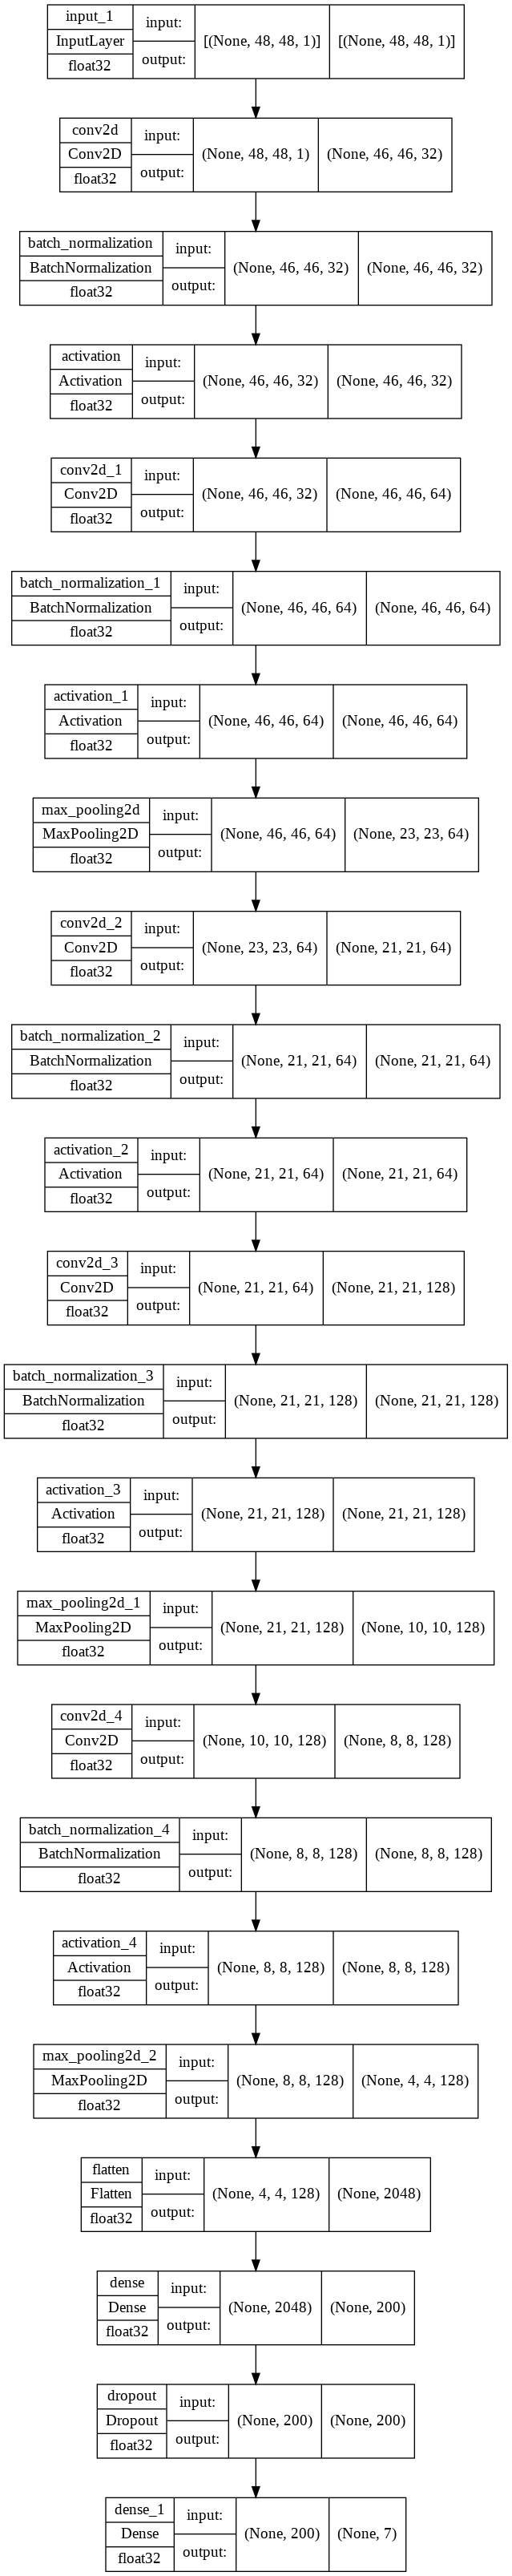

In [29]:
# We then plot it to visualize it
tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes = True, show_dtype = True)

In [30]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
# We use tf.keras.utils.to_categorical to convert the y_train results to a binary class matrix i.e. 1-hot encoding matrix
y_train = np_utils.to_categorical(y_train, 7)
y_train.shape

(56630, 7)

In [32]:
# We do the same thing for y_test
y_test = np_utils.to_categorical(y_test, 7)
y_test.shape

(6293, 7)

In [33]:
# we then train our model
history = model.fit(x_train, y_train, epochs = 30, validation_data=(x_test, y_test))

Epoch 1/30
1770/1770 [==============================] - 19s 9ms/step - loss: 1.7494 - accuracy: 0.3155 - val_loss: 1.4560 - val_accuracy: 0.4654
Epoch 2/30
1770/1770 [==============================] - 16s 9ms/step - loss: 1.4166 - accuracy: 0.4585 - val_loss: 1.2194 - val_accuracy: 0.5355
Epoch 3/30
1770/1770 [==============================] - 16s 9ms/step - loss: 1.2235 - accuracy: 0.5344 - val_loss: 1.0880 - val_accuracy: 0.5880
Epoch 4/30
1770/1770 [==============================] - 16s 9ms/step - loss: 1.0927 - accuracy: 0.5810 - val_loss: 1.0832 - val_accuracy: 0.5873
Epoch 5/30
1770/1770 [==============================] - 16s 9ms/step - loss: 1.0045 - accuracy: 0.6152 - val_loss: 0.9502 - val_accuracy: 0.6375
Epoch 6/30
1770/1770 [==============================] - 16s 9ms/step - loss: 0.9305 - accuracy: 0.6481 - val_loss: 0.9493 - val_accuracy: 0.6409
Epoch 7/30
1770/1770 [==============================] - 16s 9ms/step - loss: 0.8593 - accuracy: 0.6747 - val_loss: 0.8454 - val_ac

In [34]:
result = model.evaluate(x_test,y_test)
result

197/197 [==============================] - 1s 4ms/step - loss: 0.8690 - accuracy: 0.8268


[0.8690453171730042, 0.8267916440963745]

In [36]:
print(f"Accuracy of our model on validation data is {round(result[1] * 100, 4)}%")

Accuracy of our model on validation data is 82.6792%


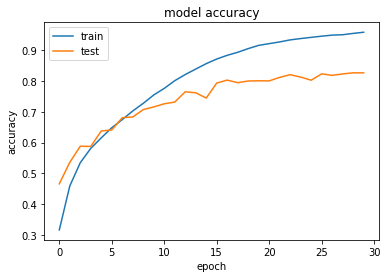

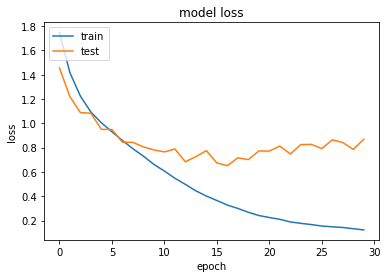

In [37]:
# we plot the accuracy and the loss function here
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
# Let's make some predictions
y_pred = model.predict(x_test)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))
y_result[:10]

[6, 5, 5, 6, 1, 6, 3, 4, 1, 2]

In [39]:
y_actual = []

for pred in y_test:
    y_actual.append(np.argmax(pred))
y_actual[:10]

[6, 5, 5, 6, 1, 0, 3, 4, 1, 3]

In [40]:
# Now we show the classification report and the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       935
           1       0.99      1.00      0.99       895
           2       0.81      0.78      0.79       880
           3       0.84      0.72      0.78       906
           4       0.69      0.74      0.72       888
           5       0.93      0.94      0.94       869
           6       0.73      0.78      0.75       920

    accuracy                           0.83      6293
   macro avg       0.83      0.83      0.83      6293
weighted avg       0.83      0.83      0.83      6293



Text(69.0, 0.5, 'Truth')

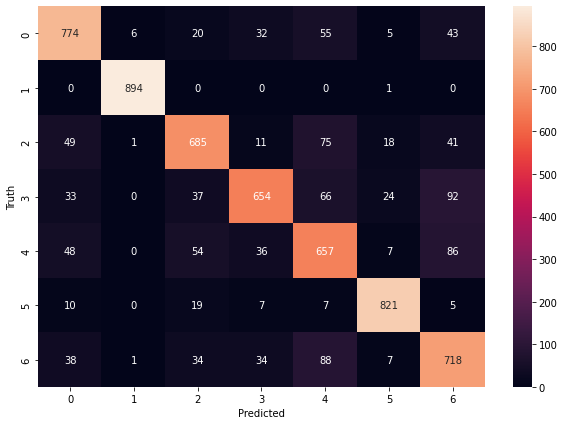

In [41]:
# we plot the confusion matrix
import seaborn as sn
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [41]:
# fer_json = model.to_json()  
# with open("fer.json", "w") as json_file:  
#     json_file.write(fer_json)  
# model.save("model.h5") 

#### Use case 2: Creating a model more robust to image pertubation
Here we apply a different set of data augmentation techniques to the base version of our model and expected an increase in model accuracy  robustness to image transformation perturbation.

In [27]:
from keras import layers

In [62]:
data_augmentation = tf.keras.Sequential([
                                        layers.RandomFlip("vertical"),
                                        layers.RandomZoom(0.1),
                                        ])

In [44]:
# We put the model together here
model_aug = Sequential([
    Input((48, 48, 1)),
    data_augmentation,
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.6),
    Dense(7, activation = 'softmax')
])
model_aug.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 48, 48, 1)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_5 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 46, 46, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                      

In [45]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
model_aug.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [70]:
history1 = model_aug.fit(x_train, y_train, epochs = 30, validation_data=(x_test, y_test))

Epoch 1/30
1770/1770 [==============================] - 19s 10ms/step - loss: 1.8957 - accuracy: 0.2251 - val_loss: 1.7265 - val_accuracy: 0.3407
Epoch 2/30
1770/1770 [==============================] - 18s 10ms/step - loss: 1.6996 - accuracy: 0.3290 - val_loss: 1.5262 - val_accuracy: 0.4195
Epoch 3/30
1770/1770 [==============================] - 18s 10ms/step - loss: 1.5602 - accuracy: 0.3951 - val_loss: 1.3827 - val_accuracy: 0.4670
Epoch 4/30
1770/1770 [==============================] - 18s 10ms/step - loss: 1.4597 - accuracy: 0.4386 - val_loss: 1.3093 - val_accuracy: 0.5130
Epoch 5/30
1770/1770 [==============================] - 18s 10ms/step - loss: 1.3811 - accuracy: 0.4712 - val_loss: 1.2830 - val_accuracy: 0.5246
Epoch 6/30
1770/1770 [==============================] - 18s 10ms/step - loss: 1.3153 - accuracy: 0.4915 - val_loss: 1.2732 - val_accuracy: 0.5141
Epoch 7/30
1770/1770 [==============================] - 18s 10ms/step - loss: 1.2670 - accuracy: 0.5098 - val_loss: 1.1520 -

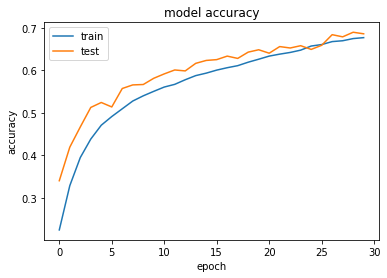

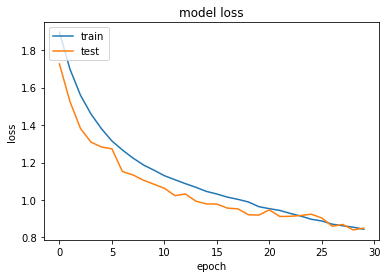

In [71]:
# we plot the accuracy and the loss function here
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [79]:
result1 = model_aug.evaluate(x_test,y_test)
result1

197/197 [==============================] - 1s 5ms/step - loss: 0.8497 - accuracy: 0.6860


[0.8496926426887512, 0.6860003471374512]

In [81]:
print(f"Accuracy of our model (with image transformation data augmentation) on validation data is {round(result1[1] * 100, 4)}%")

Accuracy of our model (with image transformation data augmentation) on validation data is 68.6%


In [72]:
# Let's make some predictions
y_pred = model_aug.predict(x_test)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))
y_result[:10]

[3, 5, 0, 6, 1, 6, 0, 4, 1, 3]

In [73]:
y_actual = []

for pred in y_test:
    y_actual.append(np.argmax(pred))
y_actual[:10]

[6, 5, 5, 6, 1, 0, 3, 4, 1, 3]

In [74]:
# Now we show the classification report and the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           0       0.65      0.60      0.62       935
           1       0.98      1.00      0.99       895
           2       0.59      0.37      0.46       880
           3       0.66      0.83      0.73       906
           4       0.47      0.55      0.51       888
           5       0.87      0.83      0.85       869
           6       0.61      0.62      0.61       920

    accuracy                           0.69      6293
   macro avg       0.69      0.69      0.68      6293
weighted avg       0.69      0.69      0.68      6293



Text(69.0, 0.5, 'Truth')

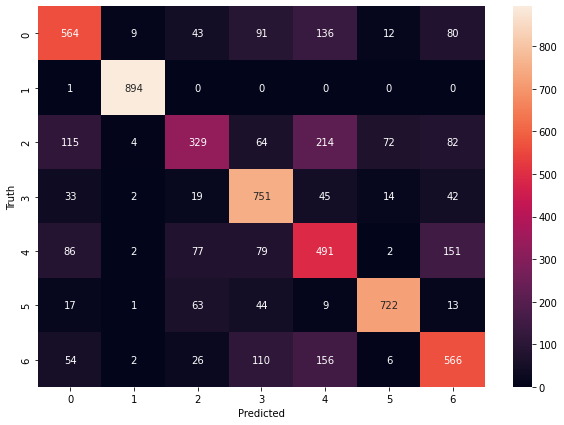

In [75]:
# we plot the confusion matrix
import seaborn as sn
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')

#### Use case 3: Streamlining the distribution of emotions in the dataset to more mainstream emotions due to the fact that when neural networks are trained on datasets containing under-represented emotions, such as disgust, they tend to misclassify those emotions. 

In [71]:
emotion_key

{0: 'Angry',
 1: 'Disgust',
 2: 'Fear',
 3: 'Happy',
 4: 'Sad',
 5: 'Surprise',
 6: 'Neutral'}

In [72]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [73]:
# Per the original distribution of emotions in the dataset,the "disgust" emotion was the most underrepresented and benefited the most
# from dataset balancing in our first use case (using random oversampler) and data augmentation via image transformations. 
# we expect that streamlining this emotion under the "angry" emotion, as well as the "fear" under the "sad" emotion.
# we will modify the dataset and then rebalance it before training. 

In [74]:
data['emotion'] = data['emotion'].map(lambda x: 1 if x == 0 else x)

In [75]:
data['emotion'] = data['emotion'].map(lambda x: 4 if x == 2 else x)

In [76]:
# We view the new distribution of emotions in the dataset
x_data = data['pixels']
y_data = data['emotion']

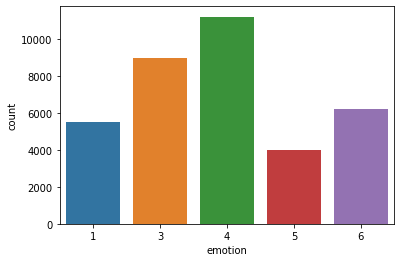

In [77]:
ax = sns.countplot(x='emotion', data=data)

In [54]:
# so we carry out random oversampling again

In [78]:
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1, 1), y_data)
print(x_data.shape," ",y_data.shape)

(55990, 1)   (55990,)


In [79]:
y_data.value_counts()

1    11198
4    11198
6    11198
3    11198
5    11198
Name: emotion, dtype: int64

In [80]:
x_data = pd.Series(x_data.flatten())
x_data

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
55985    35 37 38 41 45 50 60 76 86 92 92 92 93 94 99 1...
55986    31 51 100 132 144 141 61 26 17 14 11 13 11 10 ...
55987    64 62 70 77 77 94 108 118 127 136 138 139 153 ...
55988    149 157 151 137 99 112 83 30 26 16 24 33 46 47...
55989    192 190 192 194 194 194 195 200 200 201 202 20...
Length: 55990, dtype: object

In [81]:
x_data = np.array(list(map(str.split, x_data)), np.float32)

In [82]:
# Normalize the pixels
x_data = x_data / 255

In [83]:
# We reshape the array from a flattened vector to its original format: 48 x 48 x 1
# channel since it is a single channel image
x_data = x_data.reshape(-1, 48, 48, 1)

In [84]:
x_data.shape

(55990, 48, 48, 1)

In [85]:
x_data[0].shape

(48, 48, 1)

In [86]:
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(55990, 1)

In [87]:
# We split the data sets into train and test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

In [65]:
# We put the model together here
model_emoji = Sequential([
    Input((48, 48, 1)),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.6),
    Dense(7, activation = 'softmax')
])
model_emoji.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_10 (Bat  (None, 46, 46, 32)       128       
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 46, 46, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_11 (Bat  (None, 46, 46, 64)       256       
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 46, 46, 64)       

In [66]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
model_emoji.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [67]:
# We use tf.keras.utils.to_categorical to convert the y_train results to a binary class matrix i.e. 1-hot encoding matrix
y_train = np_utils.to_categorical(y_train, 7)
y_train.shape

(50391, 7)

In [68]:
# We do the same thing for y_test
y_test = np_utils.to_categorical(y_test, 7)
y_test.shape

(5599, 7)

In [69]:
history3 = model_emoji.fit(x_train, y_train, epochs = 30, validation_data=(x_test, y_test))

Epoch 1/30
1575/1575 [==============================] - 16s 9ms/step - loss: 1.4570 - accuracy: 0.3905 - val_loss: 1.1830 - val_accuracy: 0.5315
Epoch 2/30
1575/1575 [==============================] - 14s 9ms/step - loss: 1.1864 - accuracy: 0.5139 - val_loss: 1.0408 - val_accuracy: 0.5855
Epoch 3/30
1575/1575 [==============================] - 14s 9ms/step - loss: 1.0548 - accuracy: 0.5761 - val_loss: 0.9691 - val_accuracy: 0.6115
Epoch 4/30
1575/1575 [==============================] - 14s 9ms/step - loss: 0.9629 - accuracy: 0.6163 - val_loss: 0.8967 - val_accuracy: 0.6549
Epoch 5/30
1575/1575 [==============================] - 14s 9ms/step - loss: 0.8806 - accuracy: 0.6488 - val_loss: 0.8350 - val_accuracy: 0.6696
Epoch 6/30
1575/1575 [==============================] - 14s 9ms/step - loss: 0.8025 - accuracy: 0.6823 - val_loss: 0.7954 - val_accuracy: 0.6839
Epoch 7/30
1575/1575 [==============================] - 14s 9ms/step - loss: 0.7294 - accuracy: 0.7157 - val_loss: 0.7658 - val_ac

In [71]:
result2 = model_emoji.evaluate(x_test, y_test)
result2

175/175 [==============================] - 1s 5ms/step - loss: 0.7346 - accuracy: 0.8401


[0.734647274017334, 0.840149998664856]

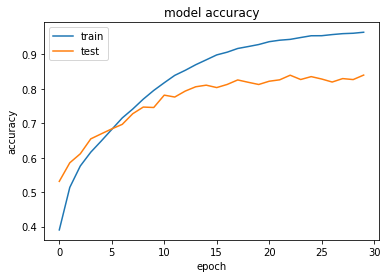

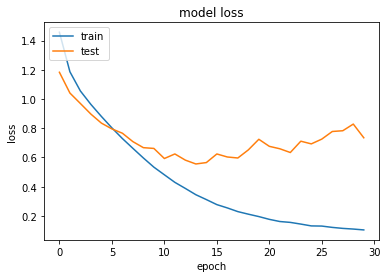

In [72]:
# we plot the accuracy and the loss function here
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [74]:
# Now we show the classification report and the confusion matrix
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       935
           1       0.99      1.00      0.99       895
           2       0.81      0.78      0.79       880
           3       0.84      0.72      0.78       906
           4       0.69      0.74      0.72       888
           5       0.93      0.94      0.94       869
           6       0.73      0.78      0.75       920

    accuracy                           0.83      6293
   macro avg       0.83      0.83      0.83      6293
weighted avg       0.83      0.83      0.83      6293



Text(69.0, 0.5, 'Truth')

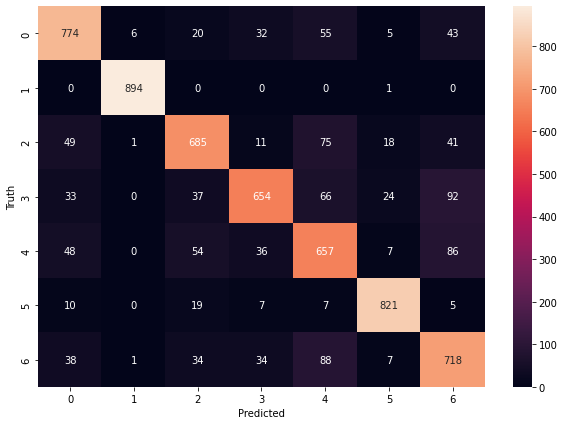

In [75]:
# we plot the confusion matrix
import seaborn as sn
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [88]:
# WE TRY A COMBO OF DATA AUGMENTATION AND IMAGE TRANSFORMATION TO MITIGATE AGAINST OVERFITTING
model_emoji_2 = Sequential([
    Input((48, 48, 1)),
    data_augmentation,
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.6),
    Dense(7, activation = 'softmax')
])
# model_emoji_2_aug.summary()

In [89]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
model_emoji_2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [90]:
# We use tf.keras.utils.to_categorical to convert the y_train results to a binary class matrix i.e. 1-hot encoding matrix
y_train = np_utils.to_categorical(y_train, 7)
y_train.shape

(50391, 7)

In [91]:
# We do the same thing for y_test
y_test = np_utils.to_categorical(y_test, 7)
y_test.shape

(5599, 7)

In [92]:
history4 = model_emoji_2.fit(x_train, y_train, epochs = 30, validation_data=(x_test, y_test))

Epoch 1/30
1575/1575 [==============================] - 30s 12ms/step - loss: 1.5777 - accuracy: 0.3152 - val_loss: 1.3570 - val_accuracy: 0.4417
Epoch 2/30
1575/1575 [==============================] - 19s 12ms/step - loss: 1.3658 - accuracy: 0.4217 - val_loss: 1.1904 - val_accuracy: 0.5172
Epoch 3/30
1575/1575 [==============================] - 19s 12ms/step - loss: 1.2657 - accuracy: 0.4766 - val_loss: 1.1235 - val_accuracy: 0.5481
Epoch 4/30
1575/1575 [==============================] - 19s 12ms/step - loss: 1.2022 - accuracy: 0.5050 - val_loss: 1.1101 - val_accuracy: 0.5501
Epoch 5/30
1575/1575 [==============================] - 19s 12ms/step - loss: 1.1442 - accuracy: 0.5290 - val_loss: 1.0488 - val_accuracy: 0.5821
Epoch 6/30
1575/1575 [==============================] - 19s 12ms/step - loss: 1.0976 - accuracy: 0.5530 - val_loss: 0.9823 - val_accuracy: 0.5990
Epoch 7/30
1575/1575 [==============================] - 19s 12ms/step - loss: 1.0678 - accuracy: 0.5663 - val_loss: 0.9745 -

In [93]:
result4 = model_emoji_2.evaluate(x_test, y_test)
result4

175/175 [==============================] - 1s 5ms/step - loss: 0.7116 - accuracy: 0.7225


[0.7116479277610779, 0.7224504351615906]

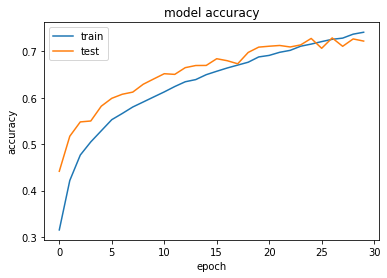

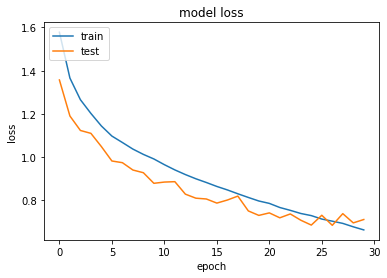

In [94]:
# we plot the accuracy and the loss function here
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [98]:
# Let's make some predictions
y_pred = model_emoji_2.predict(x_test)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))
y_result[:10]

[5, 1, 1, 5, 5, 1, 3, 3, 3, 5]

In [99]:
y_actual = []

for pred in y_test:
    y_actual.append(np.argmax(pred))
y_actual[:10]

[5, 1, 1, 5, 5, 1, 3, 3, 3, 5]

In [100]:
# Now we show the classification report and the confusion matrix
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           1       0.72      0.75      0.73      1168
           3       0.87      0.81      0.84      1151
           4       0.50      0.47      0.49      1092
           5       0.94      0.80      0.86      1108
           6       0.62      0.77      0.69      1080

    accuracy                           0.72      5599
   macro avg       0.73      0.72      0.72      5599
weighted avg       0.73      0.72      0.73      5599



Text(69.0, 0.5, 'Truth')

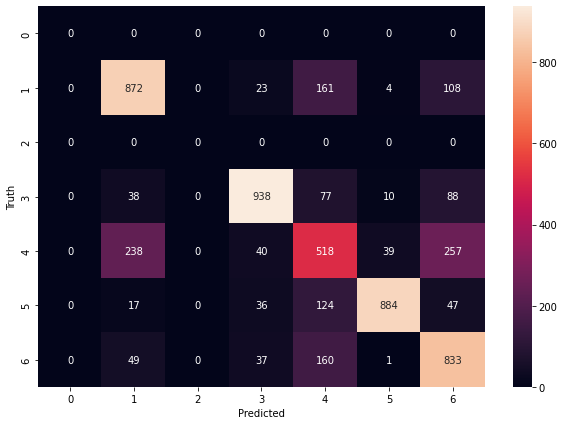

In [101]:
# we plot the confusion matrix
import seaborn as sn
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')